# Project

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Forecast of El Niño

<img alt="weather" src="images/ENSO-normal.png" width=400 style="float:left">
<img alt="weather" src="images/ENSO-El_Nino.png" width=400 style="float:right">

- Natural mode of variability of the pacific equatorial ocean
- Big impact on the local economy
- Question: What is the predictability of El Nino?

### Data set

<img alt="weather" src="images/monthly-sst-lanina-normal-elnino.png" width=400>

- Variable: Global sea surface temperature (SST)
- Temporal resolution: monthly mean
- Spatial resolution: 1 degree $\times$ 1 degree

### First steps

- Read about El nino
- Characterize El nino: i.e. introduce a classifier
- What does it mean ``to make a prediction''?

# Imports

In [25]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

from pathlib import Path

# Functions

In [2]:
def find_events(mask, min_length=6):
    """Return list of (start_date, end_date) tuples for events."""
    events = []
    in_event = False
    count = 0
    for i, val in enumerate(mask):
        if val and not in_event:
            start = mask.index[i]
            in_event = True
            count = 1
        elif val and in_event:
            count += 1
        elif not val and in_event:
            if count >= min_length:
                end = mask.index[i-1]
                events.append((start, end))
            in_event = False
 
    if in_event and count >= min_length:
        events.append((start, mask.index[-1]))
    return events

# Data

## Sea Surface Temperature (SST)

In [3]:
dir0 = Path('data')
file_sst = 'sst.mnmean.nc'

ds_sst = xr.open_dataset(Path(dir0, file_sst))
sst = ds_sst["sst"]

In [4]:
ds_sst

<xarray.Dataset> Size: 123MB
Dimensions:    (time: 475, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * lat        (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 4kB 1981-12-01 1982-01-01 ... 2021-06-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 123MB ...
    time_bnds  (time, nbnds) datetime64[ns] 8kB ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

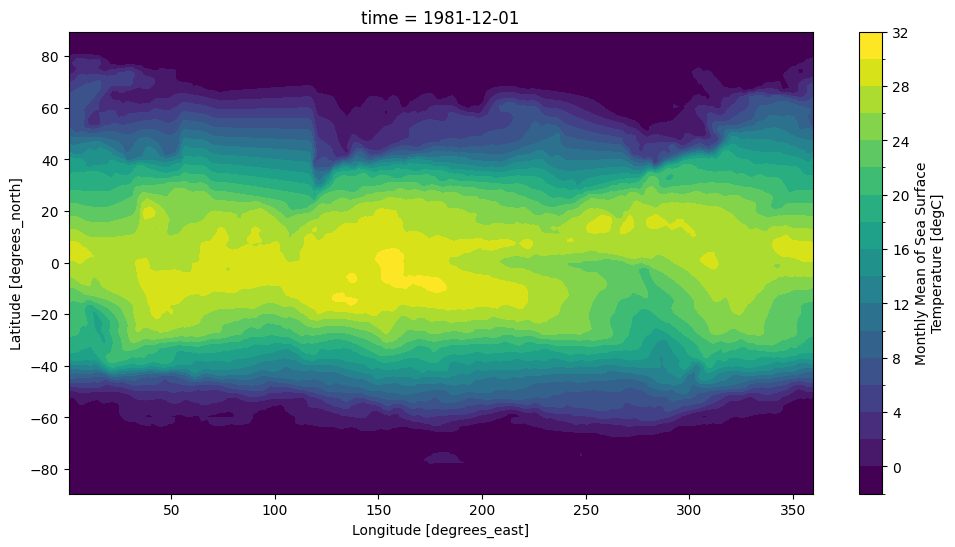

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
p = sst.isel(time=0).plot.contourf(ax=ax, levels=20, center=False)

## Mean Sea Level Pressure (MSLP)

In [6]:
file_mslp = 'mslp_coarse.nc'

ds_mslp = xr.open_dataset(Path(dir0, file_mslp))
mslp = ds_mslp['msl']

In [7]:
ds_mslp

<xarray.Dataset> Size: 138MB
Dimensions:    (time: 531, latitude: 181, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 724B 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-03-01
Data variables:
    msl        (time, latitude, longitude) float32 138MB ...
Attributes:
    Conventions:                 CF-1.6
    NCO:                         netCDF Operators version 4.9.1 (Homepage = h...
    title:                       ERA5 reanalysis
    data_type:                   1xmonthly fields analysis
    grid_resolution_in_degrees:  0.25
    source:                      credit: ECMWF, COPERNICUS Climate Change Ser...
    history:                     Thu Nov 30 14:28:43 2023: ncks -d longitude,...

# Characterizing El niño

* **Definition:** According to the National Center for Atmospheric Research (NCAR), an El Niño event occurs when the 5-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region (5° N–5° S, 120°–170° W) remains above +0.4 °C for at least six consecutive months.

Given that we have nearly 40 years of data (from December 1981 to June 2021), we will use the first 30 years as the base period climatology, that is, the set of average temperatures for each of the 12 calendar months. Using this baseline, we will then compute SST anomalies for the entire time span.

1. Analyze monthly mean SSTs in 2° x 2° grids.
2. Calculate monthly SST anomalies averaged for the area 5°N-5°S and 90°-150°W. This is essentially the region known as "Niño 3".
3. Find periods during which 5-month running means of the monthly SST anomalies in the above mentioned area are +0.5°C or more for at least six consecutive months.

In [8]:
nino_3   = dict(lat=slice(5, -5), lon=slice(210, 270))   # Niño 3 (150°W–90°W)
nino_34  = dict(lat=slice(5, -5), lon=slice(190, 240))   # Niño 3.4 (170°W–120°W)

sst_nino_3  = sst.sel(**nino_3).mean(dim=["lat", "lon"])
sst_nino_34 = sst.sel(**nino_34).mean(dim=["lat", "lon"])

In [9]:
nino_3_30y = sst_nino_3.sel(time=slice("1981-12", "2011-12"))
climatology_3 = nino_3_30y.groupby("time.month").mean("time")
nino_3_anom = sst_nino_3.groupby("time.month") - climatology_3

nino_34_30y = sst_nino_34.sel(time=slice("1981-12", "2011-12"))
climatology_34 = nino_34_30y.groupby("time.month").mean("time")
nino_34_anom = sst_nino_34.groupby("time.month") - climatology_34

## El Niño 3

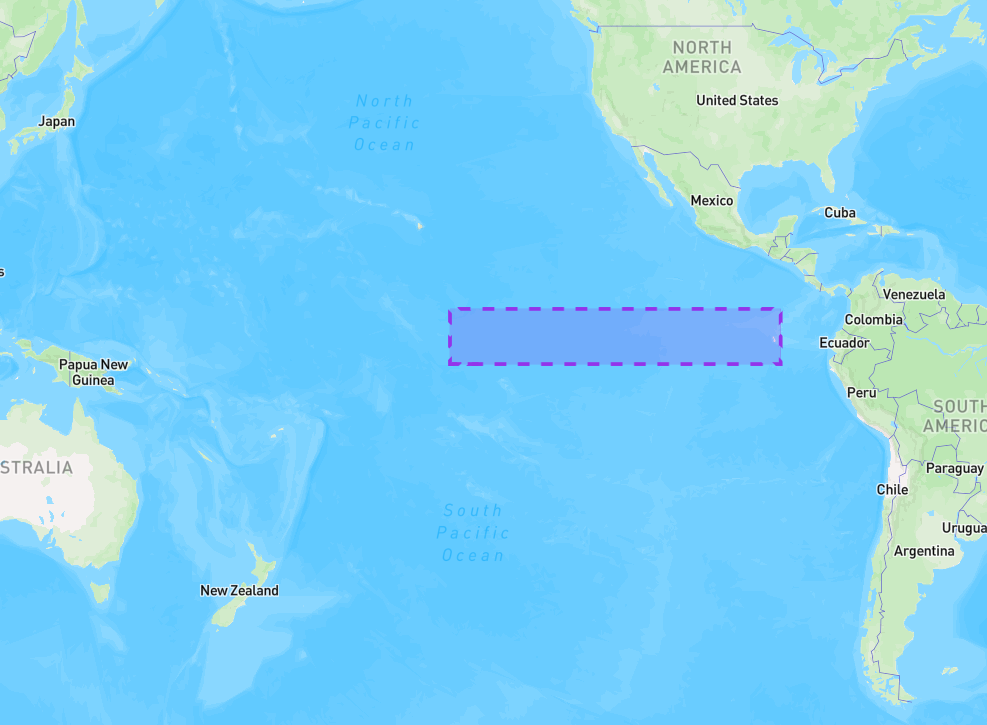

### Monthly average SST

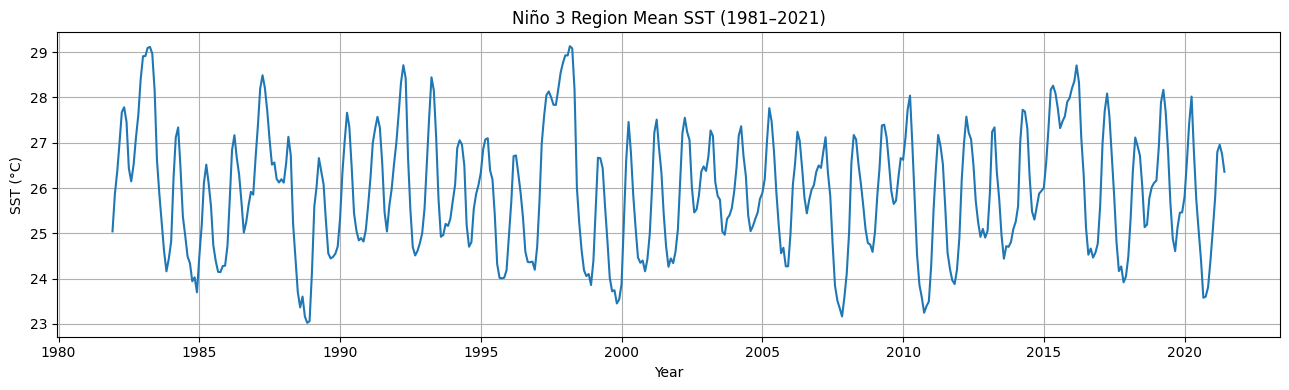

In [10]:
plt.figure(figsize=(13, 4))
plt.plot(sst_nino_3['time'], sst_nino_3)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3 Region Mean SST (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.tight_layout()
plt.show()

In [11]:
nino_3_5mo = nino_3_anom.rolling(time=5, center=True).mean()
anom = nino_3_5mo.to_series()

# El Niño and La Niña conditions
is_elnino = anom > 0.5
is_lanina = anom < -0.5

elnino_periods_nino3 = find_events(is_elnino)
lanina_periods_nino3 = find_events(is_lanina)

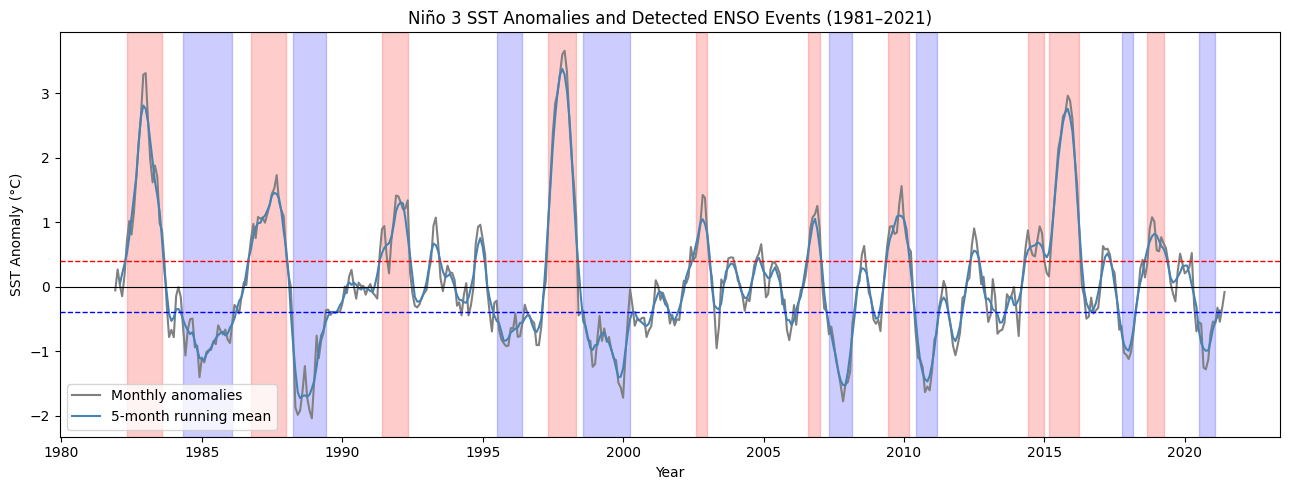

In [12]:
plt.figure(figsize=(13,5))
plt.plot(anom.index, nino_3_anom, color='gray', label='Monthly anomalies')
plt.plot(anom.index, anom, color='steelblue', label='5-month running mean')

plt.axhline(0.4, color='red', linestyle='--', linewidth=1)
plt.axhline(-0.4, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=0.8)

# Shade El Niño and La Niña events
for start, end in elnino_periods_nino3:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in lanina_periods_nino3:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3 SST Anomalies and Detected ENSO Events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.tight_layout()
plt.show()

We define a dataframe with flags that refer to the phase of each month:

| Flag | ENSO Phase |
| :- | -: |
| **2** | El Niño |
| **1** | La Niña |
| **0** | Neither |

In [13]:
df3 = pd.DataFrame({
    'timestamp': anom.index,
    'mean_SST': sst_nino_3,
    'monthly_anom': nino_3_anom,
    '5mo_running_anom': anom,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in elnino_periods_nino3:
    df3.loc[(df3.index >= start) & (df3.index <= end), "flag"] = 2
for start, end in lanina_periods_nino3:
    df3.loc[(df3.index >= start) & (df3.index <= end), "flag"] = 1

df3.head()

,timestamp,mean_SST,monthly_anom,5mo_running_anom,flag
time,,,,,
1981-12-01,1981-12-01,25.043583,-0.057739,NaN,0
1982-01-01,1982-01-01,25.868416,0.267347,NaN,0
1982-02-01,1982-02-01,26.374184,0.013208,0.050568,0
1982-03-01,1982-03-01,26.974382,-0.147890,0.201229,0
1982-04-01,1982-04-01,27.675814,0.177916,0.351203,0


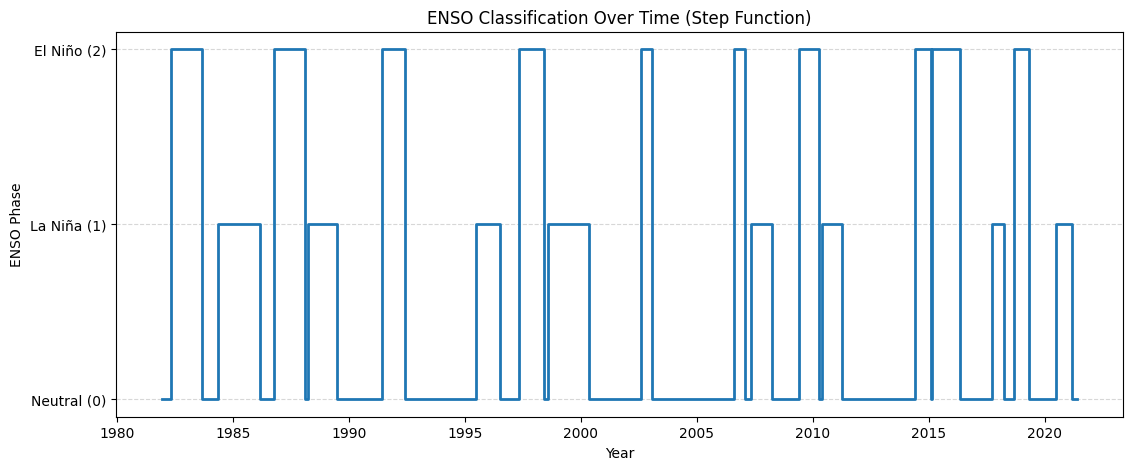

In [14]:
plt.figure(figsize=(13,5))
plt.step(df3.index, df3["flag"], where="post", linewidth=2)
plt.yticks([0,1,2], ["Neutral (0)", "La Niña (1)", "El Niño (2)"])
plt.xlabel("Year")
plt.ylabel("ENSO Phase")
plt.title("ENSO Classification Over Time (Step Function)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()

#### Things to explore

1) trend: (1) regressão linear, ver se o R^2 e coeff é relevante o suficiente (p-value) (2) decomposição ARIMA -> importante pra checar se a baseline é válida (n pode ter trend) -> o que fazer se tiver?

2) [Não necessariamente fazer, mas é uma sequencia] PCA em região específica para ver se tem outros index interessantes (se as regiões 3 e 3.4 são as mais explicativas)

3) [paralelo] flag de fenomenos e ver a sazonalidade deles (checar se é possivel)
- lag correlation (delayed oscillator) tanto entre as regiões quanto com a pressão
- flag de fenomenos e ver a sazonalidade deles (checar se é possivel)
- classificação: colocar flags de fenomeno (el nino, la nina, nada) no tempo e ver se tem classificações de SOI (intervalos de valores que sempre batem)

#### Coisas chatinhas
- gráfico do SOI

## El Niño 3.4

### Monthly average SST

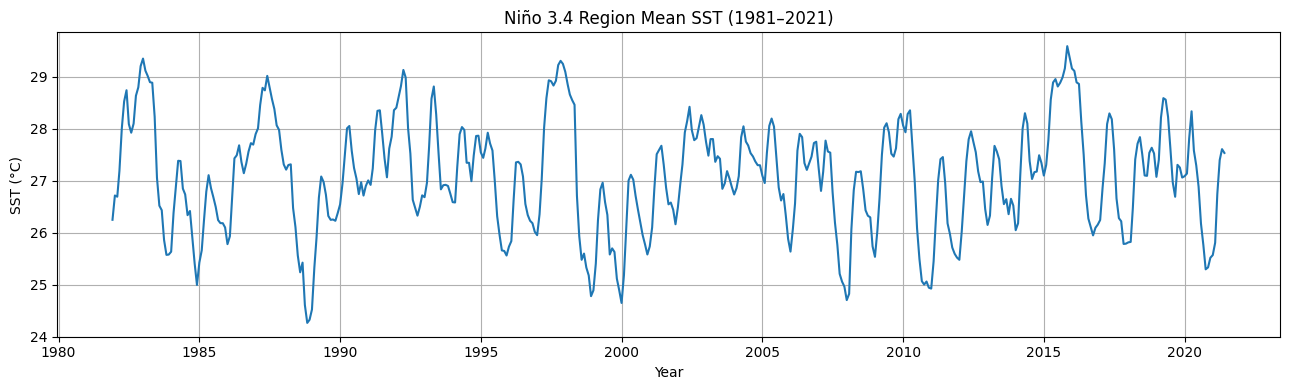

In [15]:
plt.figure(figsize=(13, 4))
plt.plot(sst_nino_34['time'], sst_nino_34)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3.4 Region Mean SST (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.tight_layout()
plt.show()

### SST Anomalies

In [16]:
nino_34_5mo = nino_34_anom.rolling(time=5, center=True).mean()
anom = nino_34_5mo.to_series()

# El Niño and La Niña conditions
is_elnino = anom > 0.4
is_lanina = anom < -0.4

elnino_periods_nino34 = find_events(is_elnino)
lanina_periods_nino34 = find_events(is_lanina)

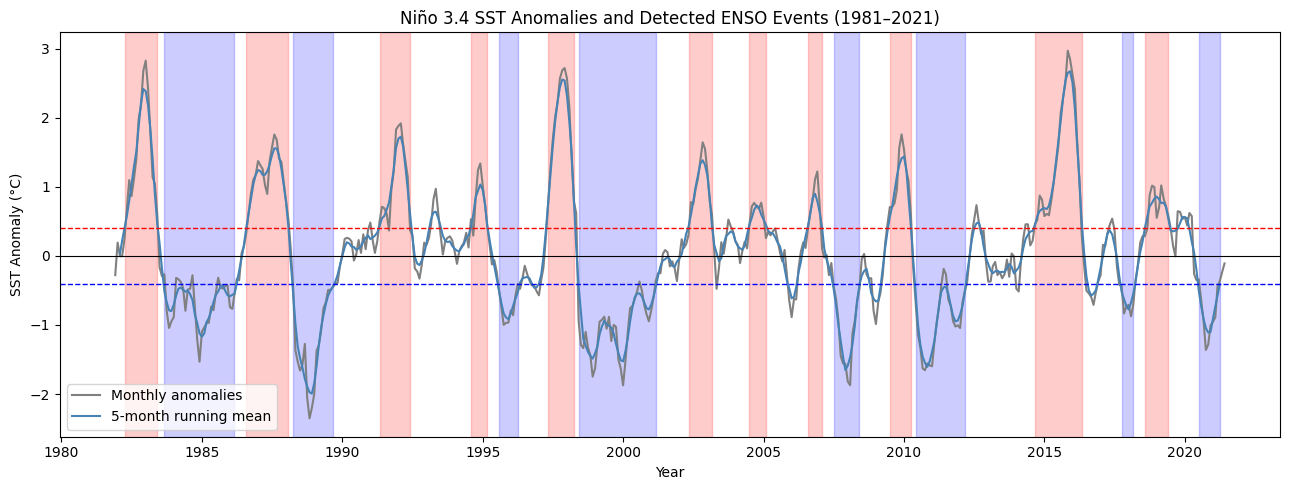

In [17]:
plt.figure(figsize=(13,5))
plt.plot(anom.index, nino_34_anom, color='gray', label='Monthly anomalies')
plt.plot(anom.index, anom, color='steelblue', label='5-month running mean')

plt.axhline(0.4, color='red', linestyle='--', linewidth=1)
plt.axhline(-0.4, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=0.8)

# Shade El Niño and La Niña events
for start, end in elnino_periods_nino34:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in lanina_periods_nino34:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3.4 SST Anomalies and Detected ENSO Events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.tight_layout()
plt.show()

Flags

In [18]:
df34 = pd.DataFrame({
    'timestamp': anom.index,
    'mean_SST': sst_nino_34,
    'monthly_anom': nino_34_anom,
    '5mo_running_anom': anom,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in elnino_periods_nino34:
    df34.loc[(df34.index >= start) & (df34.index <= end), "flag"] = 2
for start, end in lanina_periods_nino34:
    df34.loc[(df34.index >= start) & (df34.index <= end), "flag"] = 1

## Southern Oscillation Index (SOI)

The Southern Oscillation Index (SOI) is a measure of the atmospheric part of ENSO — the pressure difference between the western and eastern tropical Pacific.
* **El Niño:** low pressure in the east (negative SOI) + warm SST anomalies.

In [18]:
# Extract grid cells near Tahiti and Darwin
tahiti = mslp.sel(latitude=-17.5, longitude=210, method='nearest')
darwin = mslp.sel(latitude=-12.5, longitude=131, method='nearest')

soi_raw = tahiti - darwin

# Exploratory Analysis

## Lag correlation

### Global SST vs. Niño 3.4

In [19]:
max_lag = 12
lag_corr = []

for lag in range(max_lag+1):
    n34_shifted = nino_34_anom.shift(time=-lag)
    corr = xr.corr(sst, n34_shifted, dim='time')
    lag_corr.append(corr)

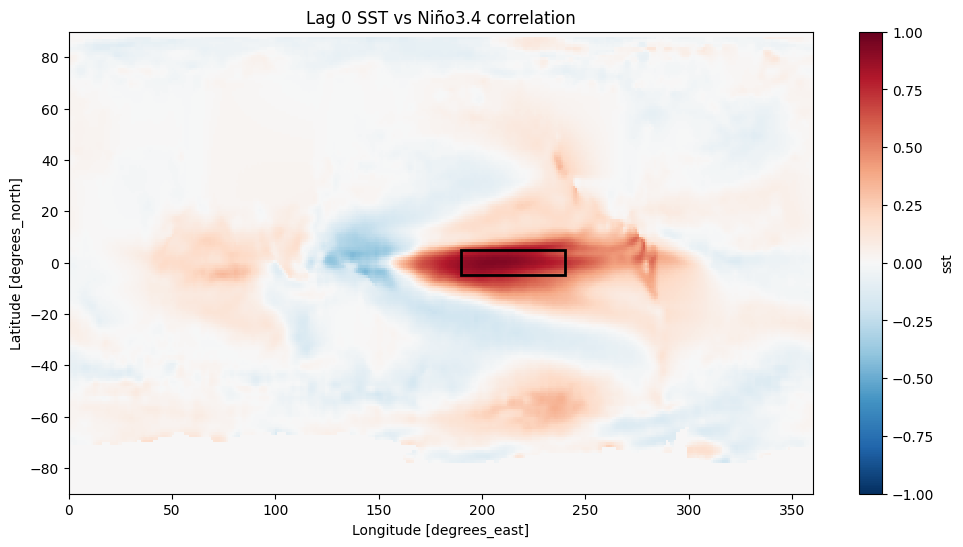

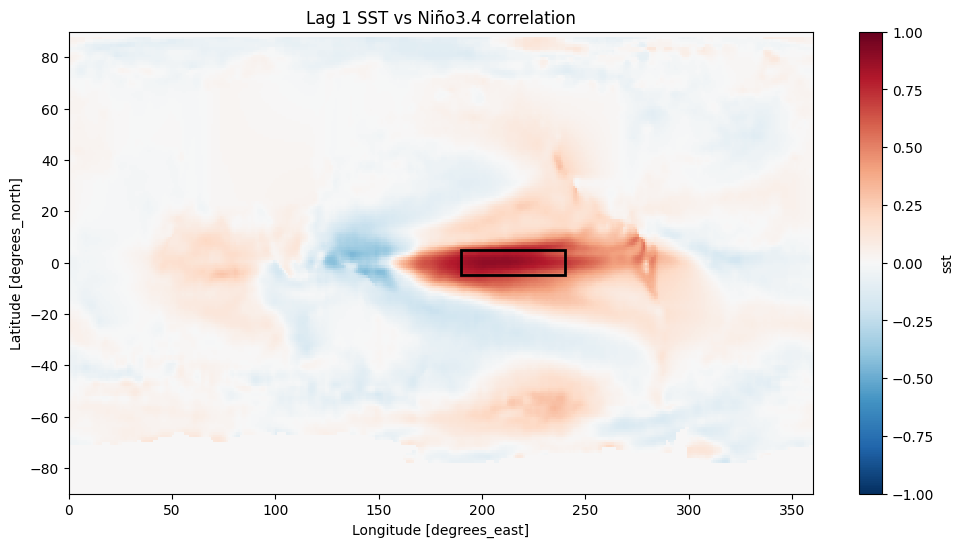

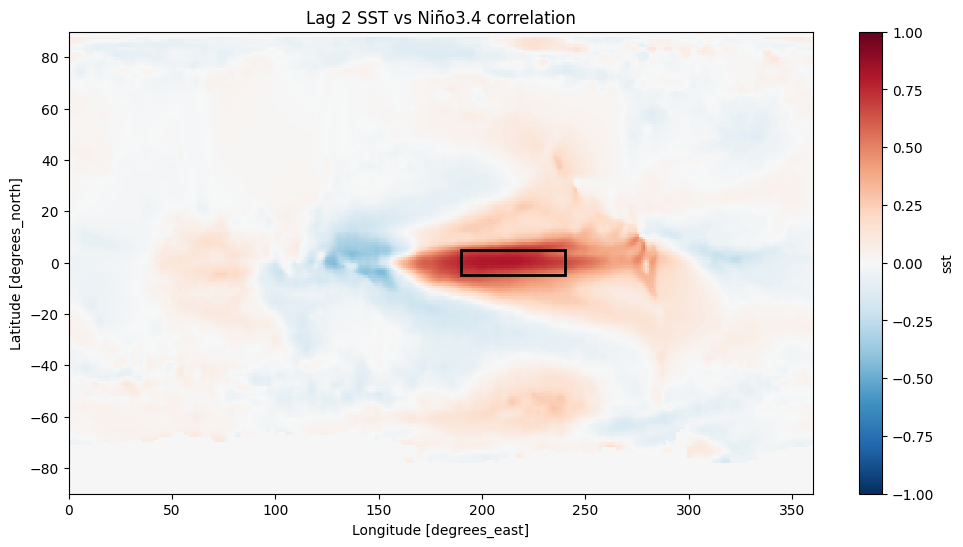

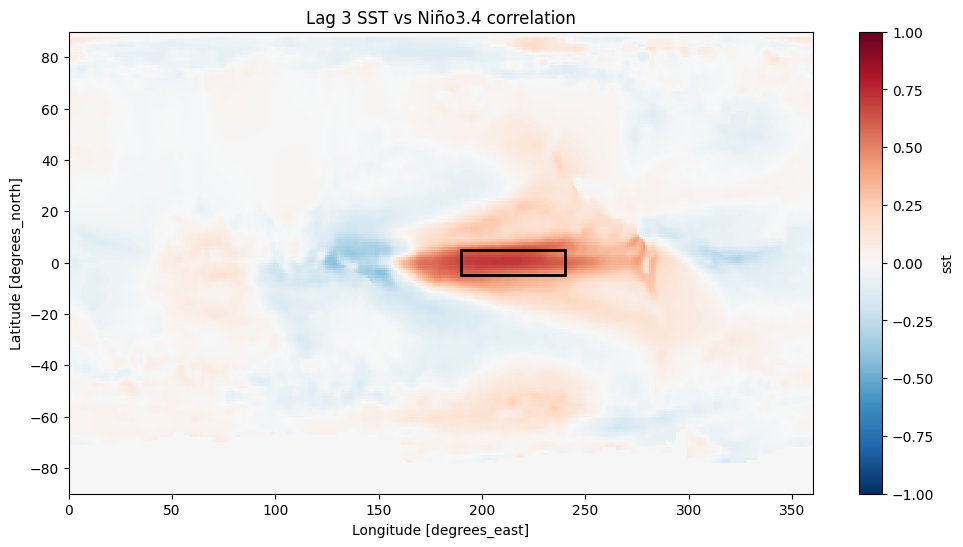

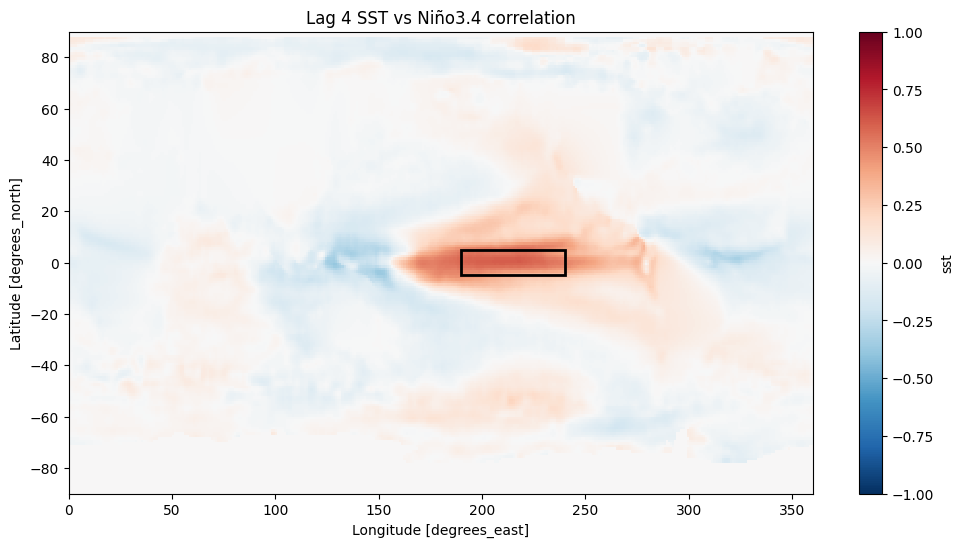

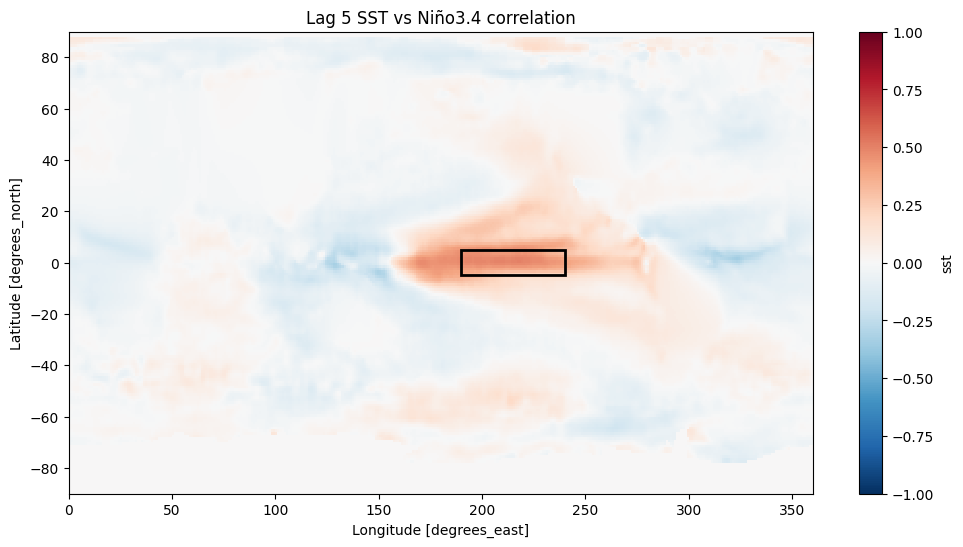

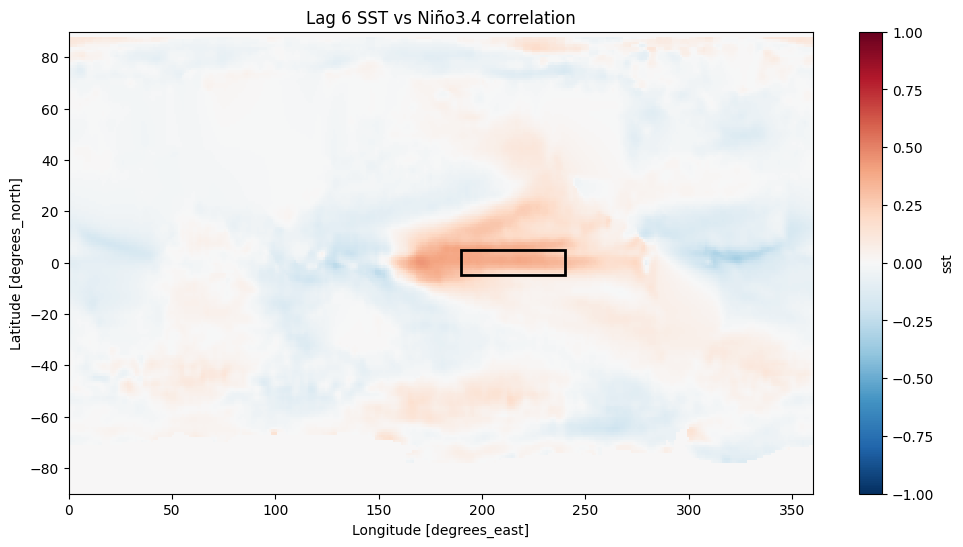

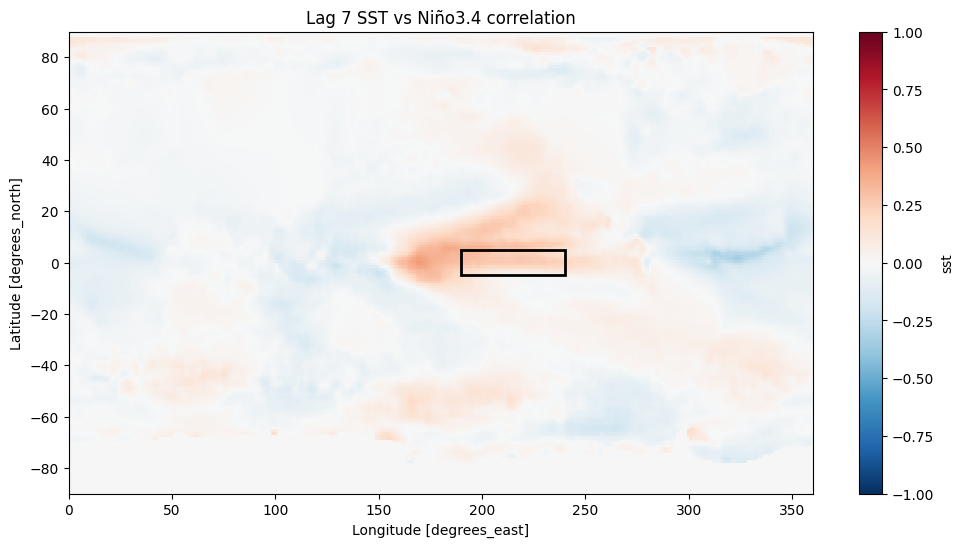

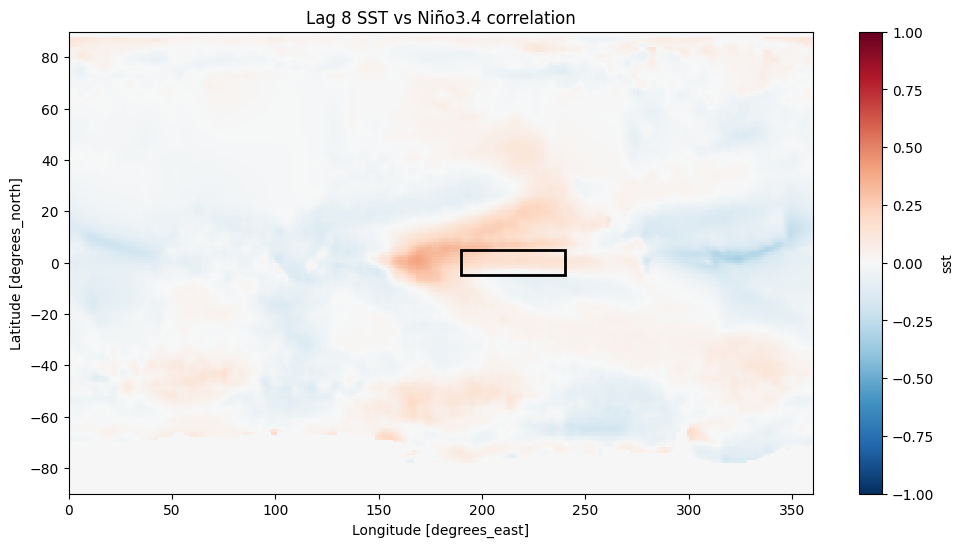

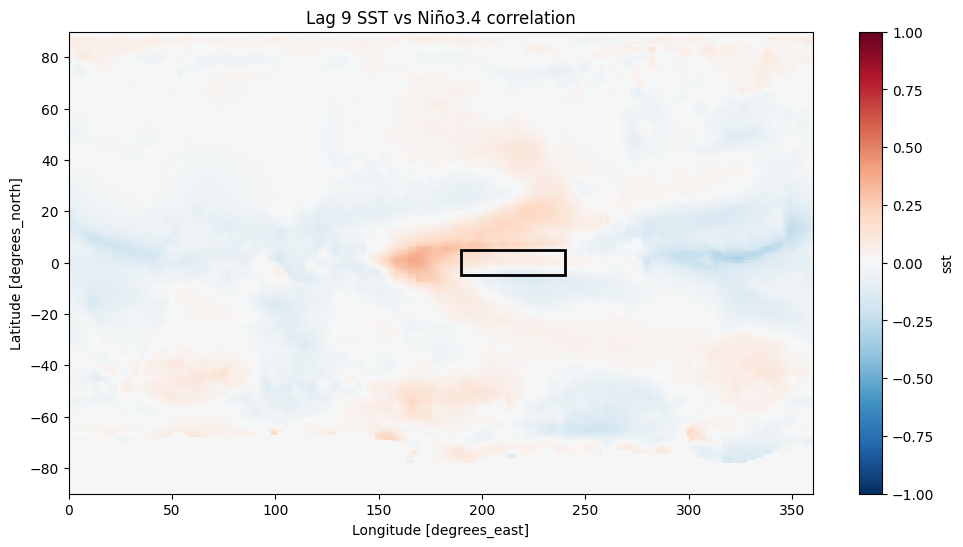

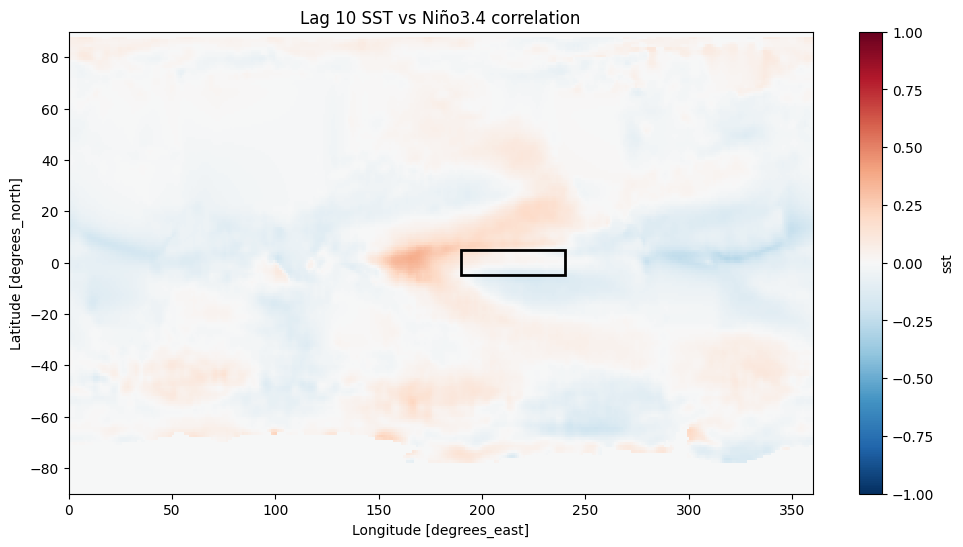

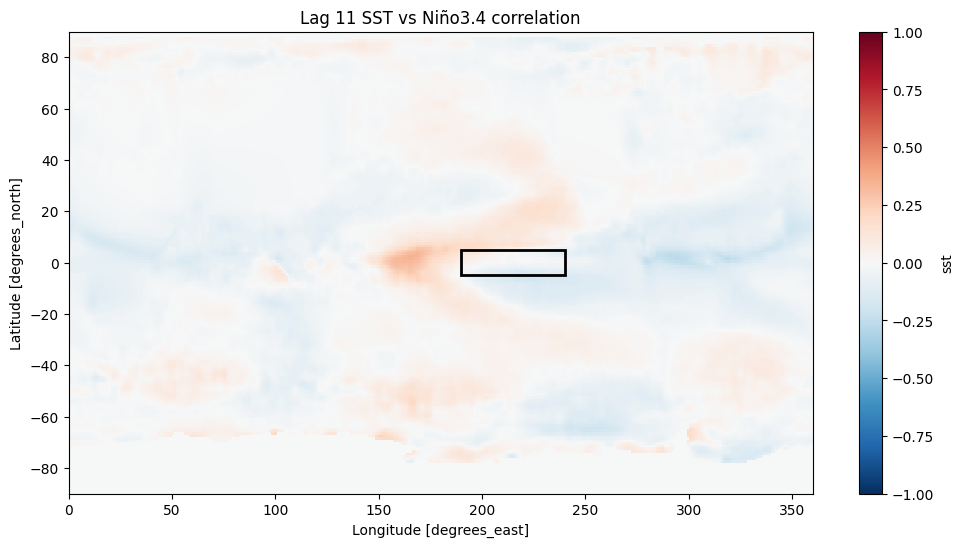

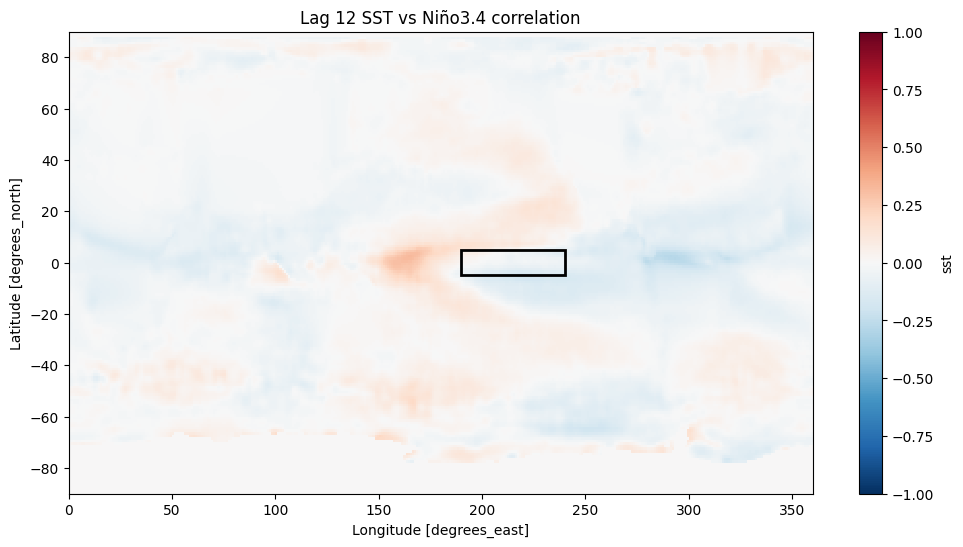

In [28]:
# Niño 3.4 bounds
lat_min, lat_max = -5, 5
lon_min, lon_max = 190, 240

for lag in range(13):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    lag_corr[lag].plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    
    rect = patches.Rectangle((lon_min, lat_min),lon_max - lon_min,lat_max - lat_min,linewidth=2,edgecolor='black',facecolor='none')
    ax.add_patch(rect)
    
    ax.set_title(f"Lag {lag} SST vs Niño3.4 correlation")
    plt.show()

In [20]:
lag_corr

[<xarray.DataArray 'sst' (lat: 180, lon: 360)> Size: 259kB
 array([[5.0766552e-08, 5.0766552e-08, 5.0766552e-08, ..., 5.0766552e-08,
         5.0766552e-08, 5.0766552e-08],
        [5.0766552e-08, 5.0766552e-08, 5.0766552e-08, ..., 5.0766552e-08,
         5.0766552e-08, 5.0766552e-08],
        [7.6938444e-03, 1.1844734e-02, 1.1205115e-02, ..., 1.1896652e-02,
         1.3351466e-02, 1.5954271e-02],
        ...,
        [5.0766552e-08, 5.0766552e-08, 5.0766552e-08, ..., 5.0766552e-08,
         5.0766552e-08, 5.0766552e-08],
        [5.0766552e-08, 5.0766552e-08, 5.0766552e-08, ..., 5.0766552e-08,
         5.0766552e-08, 5.0766552e-08],
        [5.0766552e-08, 5.0766552e-08, 5.0766552e-08, ..., 5.0766552e-08,
         5.0766552e-08, 5.0766552e-08]], dtype=float32)
 Coordinates:
   * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
   * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5,
 <xarray.DataArray 'sst' (lat: 180, lon: 360)> Size:

# References

- https://journals.ametsoc.org/view/journals/bams/78/12/1520-0477_1997_078_2771_tdoeno_2_0_co_2.pdf
- https://www.ncei.noaa.gov/access/monitoring/enso/soi

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>